为了在Python中方便地操作图数据，我们使用流行的NetworkX库。首先创建一个无向图G=(N,E)，其中N为节点集合，E为边集合，运行代码如下。

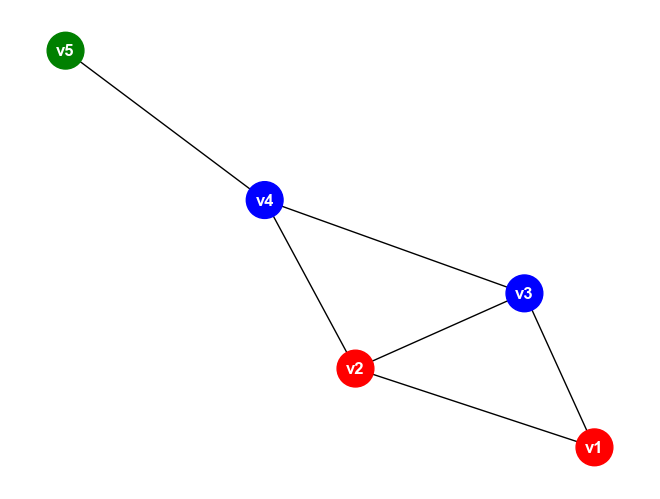

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

N = [(f'v{i}',0) for i in range(1, 3)] + [(f'v{i}',1) for i in range(3, 5)] + [(f'v{i}',2) for i in range(5, 6)]

E = [('v1', 'v2'), ('v1', 'v3'), 
     ('v2', 'v1'), ('v2', 'v3'), ('v2', 'v4'),
     ('v3', 'v1'), ('v3', 'v2'), ('v3', 'v4'),
     ('v4', 'v2'), ('v4', 'v3'), ('v4', 'v5'),
     ('v5', 'v4')
     ]
G = nx.Graph()
G.add_nodes_from(list(map(lambda x: x[0], N)))
G.add_edges_from(E)

ncolor = ['r'] * 2 + ['b'] * 2 + ['g'] * 1
nsize = [700] * 2 + [700] * 2 + [700]

nx.draw(G, with_labels=True, font_weight='bold', font_color='w', node_color=ncolor, node_size=nsize)
plt.show()

实现传递规则：

$$f(\textbf{X}, \textbf{A}) = \textbf{AX}$$

其中，$\textbf{A}$为邻接矩阵

In [3]:
import numpy as np

A = np.array(nx.adjacency_matrix(G).todense())
A

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 1, 0],
       [0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0]])

生成模拟的节点特征矩阵$\textbf{X}$

In [4]:
X = np.array([
     [i, -i, i+2]
     for i in range(A.shape[0])
])
X

array([[ 0,  0,  2],
       [ 1, -1,  3],
       [ 2, -2,  4],
       [ 3, -3,  5],
       [ 4, -4,  6]])

**进行信息聚合：使用矩阵乘法计算每个节点的一维卷积**

在这里我们将节点的一维卷积定义为节点周边对应特征值的和，此时矩阵乘法即可直接用于计算卷积。

这其中的数学原理相对比较巧妙：

已知邻接矩阵$\textbf{A}_{(n\times n)}$，节点特征矩阵$\textbf{X}_{(n\times m)}$

使用上面的定义，对于卷积而言，节点$v_i$在第$j$个特征上的的一维卷积的公式可以写作：

$$Cov_{ij} = \sum_{k\in ne_i} X_{kj}$$

其中，$ne_i$指节点$v_i$的邻居节点集合，$X_{kj}$指第$k$个节点的第$j$个特征

而矩阵乘法可以表示为：

$$\textbf{AX} = 

\begin{bmatrix}
    \sum_{i=1}^n A_{1i}X_{i1} & \sum_{i=1}^n A_{1i}X_{i2} & ... & \sum_{i=1}^n A_{1i}X_{im}\\
    \vdots \\
    \sum_{i=1}^n A_{ni}X_{i1} & \sum_{i=1}^n A_{ni}X_{i2} & ... & \sum_{i=1}^n A_{ni}X_{im}\\
    \end{bmatrix}

=\begin{bmatrix}
    Cov_{11} & Cov_{12} & ... & Cov_{im}\\
    \vdots \\
    Cov_{n1} & Cov_{n2} & ... & Cov_{nm}\\
    \end{bmatrix}
    
$$
    
其中，$\textbf{A}$为邻接矩阵，$\textbf{X}$为节点特征矩阵，$\textbf{AX}$为节点的一维卷积矩阵，即新的特征矩阵

因此，我们可以直接使用矩阵乘法来计算节点的一维卷积。

In [7]:
A_hat = A + np.eye(A.shape[0]) # 添加自环，防止自身信息丢失
A_hat @ X

array([[  3.,  -3.,   9.],
       [  6.,  -6.,  14.],
       [  6.,  -6.,  14.],
       [ 10., -10.,  18.],
       [  7.,  -7.,  11.]])

简化矩阵表示：

In [14]:
A_sum = np.sum(A_hat, axis=0)
D = np.diag(A_sum)  
D

array([[3., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 2.]])

矩阵归一化的第一种方法：

$$A_{scale} = \hat_{D}^{-1}\cdot \hat{A}$$


In [10]:
D_1 = np.diag(D) ** (-1) * np.eye(A_hat.shape[0])
A_scale = D_1 @ A_hat
A_scale

array([[0.33333333, 0.33333333, 0.33333333, 0.        , 0.        ],
       [0.25      , 0.25      , 0.25      , 0.25      , 0.        ],
       [0.25      , 0.25      , 0.25      , 0.25      , 0.        ],
       [0.        , 0.25      , 0.25      , 0.25      , 0.25      ],
       [0.        , 0.        , 0.        , 0.5       , 0.5       ]])

In [11]:
X_new = A_scale @ X
X_new

array([[ 1. , -1. ,  3. ],
       [ 1.5, -1.5,  3.5],
       [ 1.5, -1.5,  3.5],
       [ 2.5, -2.5,  4.5],
       [ 3.5, -3.5,  5.5]])

矩阵归一化的第二种方法：

$$A_{scale} = \hat_{D}^{-1}\cdot \hat{A} \cdot \hat_{D}^{-1}$$


In [13]:
scale_factor = D_1 @ A_hat @ D_1
scale_factor

array([[0.11111111, 0.08333333, 0.08333333, 0.        , 0.        ],
       [0.08333333, 0.0625    , 0.0625    , 0.0625    , 0.        ],
       [0.08333333, 0.0625    , 0.0625    , 0.0625    , 0.        ],
       [0.        , 0.0625    , 0.0625    , 0.0625    , 0.125     ],
       [0.        , 0.        , 0.        , 0.125     , 0.25      ]])

In [15]:
scale_factor @ X

array([[ 0.25      , -0.25      ,  0.80555556],
       [ 0.375     , -0.375     ,  0.91666667],
       [ 0.375     , -0.375     ,  0.91666667],
       [ 0.875     , -0.875     ,  1.5       ],
       [ 1.375     , -1.375     ,  2.125     ]])

矩阵归一化的第三种方法：

$$A_{scale1} = \hat_{D}^{-\frac{1}{2}}\cdot \hat{A} \cdot \hat_{D}^{-\frac{1}{2}}$$

In [16]:
D_sq_half = np.diag(D) ** (-0.5) * np.eye(A_hat.shape[0])
scale_factor2 = D_sq_half @ A_hat @ D_sq_half
x_new2 = scale_factor2 @ X
x_new2

array([[ 0.8660254 , -0.8660254 ,  2.68739261],
       [ 1.5       , -1.5       ,  3.57735027],
       [ 1.5       , -1.5       ,  3.57735027],
       [ 2.91421356, -2.91421356,  5.12132034],
       [ 3.06066017, -3.06066017,  4.76776695]])

**一般情况下需要考虑权值矩阵，从而对不同维度的特征进行权重打分**

此时聚合公式为：

$$cov=AXW$$

其中，$W$为权值矩阵


In [18]:
# 这里直接给出权重矩阵，特征权值在实际情下需要学习得到

W = np.array([
     [0.13, 0.24],
     [0.37, -0.23],
     [0.14, -0.15]
])
x_new2 @ W

array([[ 0.16838887,  0.00392305],
       [ 0.14082904,  0.16839746],
       [ 0.14082904,  0.16839746],
       [ 0.01757359,  0.60148232],
       [-0.06707107,  0.72334524]])

在卷积层之后添加ReLU激活函数

ReLU：

$$f(x)=x \ if \ x > 0 \ else \ 0$$

In [19]:
logits = x_new2 @ W
y = logits * (logits > 0)
y 

array([[ 0.16838887,  0.00392305],
       [ 0.14082904,  0.16839746],
       [ 0.14082904,  0.16839746],
       [ 0.01757359,  0.60148232],
       [-0.        ,  0.72334524]])

In [20]:
from torch.nn.functional import relu
import torch

y = relu(torch.tensor(logits))
y

tensor([[0.1684, 0.0039],
        [0.1408, 0.1684],
        [0.1408, 0.1684],
        [0.0176, 0.6015],
        [0.0000, 0.7233]], dtype=torch.float64)

添加softmax函数对y进行概率化

softmax：

$$softmax(\textbf{X},x_i) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

In [22]:
from torch.nn.functional import softmax

prob = softmax(y, dim=0)
prob

tensor([[0.2150, 0.1383],
        [0.2092, 0.1631],
        [0.2092, 0.1631],
        [0.1849, 0.2515],
        [0.1817, 0.2840]], dtype=torch.float64)

添加argmax函数

In [23]:
np.argmax(prob.numpy(), axis=1)

array([0, 0, 0, 1, 1])